# Bayesian Linear Regression
$$
\mathbf{y} \sim \mathcal{N} \left(w^T \mathbf{X}, \sigma^2 \mathbf{I} \right)
$$
Response datapoints $y$ are sampled from a multivariate normal distribution that has a mean equal to the product of the $w$ coefficients and the predictors, $X$, and a variance of $\sigma^2$. Here, $I$ refers to the identity matrix, which is necessary because the distribution is multivariate.

In [1]:
%matplotlib inline
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#Need scipy because dataset is in matlab format
import scipy.stats
import scipy.io
from theano import shared
from sklearn.model_selection import train_test_split

Using cuDNN version 7003 on context None
Mapped name None to device cuda: GeForce GTX 1080 Ti (0000:01:00.0)


## Load Dataset

In [2]:
mat = scipy.io.loadmat('data/olympics.mat')
olympics = mat['male100'][:, :2]

In [3]:
datx = olympics[:,0]
daty = olympics[:,1]

meanx = datx.mean()
stdx = datx.std()
meany = daty.mean()
stdy = daty.std()
datx = (datx-meanx)/stdx
daty = (daty-meany)/stdy
#datx= datx.astype(np.float32).reshape((datx.shape[0], 1))
#daty = daty.astype(np.float32).reshape((daty.shape[0], 1))

X, X_test, y, y_test = train_test_split(
            datx, daty, test_size=0.2)

Normalize and split data into training and test sets

In [4]:
#Needed because we want to be able to change the data variable x takes so that we can do predictive checks later
x = shared(X)

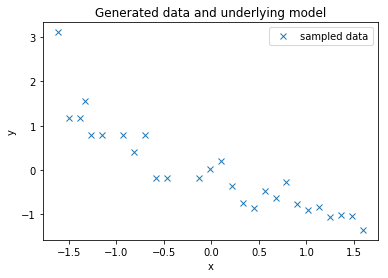

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(datx, daty, 'x', label='sampled data')
plt.legend(loc=0);

Note that we have not normalized the data and this should impact the performance of the sampler.

In [6]:
with pm.Model() as model:
    sigma = pm.HalfCauchy('sigma', beta=10)
    intercept = pm.Normal('Intercept', 0, sd=100)
    x_coeff = pm.Normal('w', 0, sd=100)
    x_coeff1 = pm.Normal('w1', 0, sd=100)
    x_coeff2 = pm.Normal('w2', 0, sd=100)
    mu=intercept + x_coeff * x+ x_coeff1*(x**2)+x_coeff2*(x**3)

    likelihood = pm.distributions.Normal('likelihood', mu,
                        sd=sigma, observed=y)
    
    # Calculate the trace
    trace = pm.sample(2000, njobs=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [w2, w1, w, Intercept, sigma_log__]
100%|██████████| 2500/2500 [00:09<00:00, 250.34it/s]


## Reading Traceplots

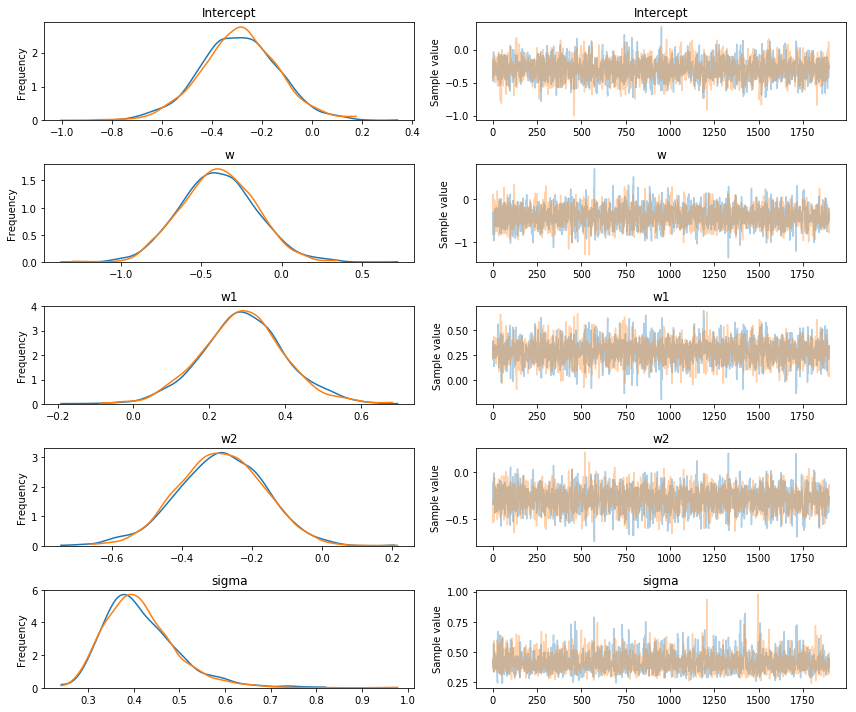

In [7]:
pm.traceplot(trace[100:])
plt.tight_layout();

The plots in the left shows the marginal posterior. For each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is. We want the peaks to be as close as possible to the truth values and as narrow as possible to ensure certainty. Note that we shouldn't force this because we might end up with wrong results.

The plots in the right is interesting becaue it show the sampling chains for the individual parameters. We need to be observing these to identify large drifts or other odd patterns which may suggest that out sampling hasn't converged and therefore, we are prone to wrong estimations. 

Given below is another source of information.

In [8]:
print(pm.summary(trace[-1000:]))  

               mean        sd  mc_error   hpd_2.5  hpd_97.5   n_eff      Rhat
Intercept -0.294382  0.152796  0.004983 -0.619980 -0.004011  1101.0  0.999820
w         -0.390610  0.226404  0.006496 -0.825698  0.050656  1054.0  0.999633
w1         0.288163  0.109604  0.003340  0.075148  0.511260  1160.0  0.999636
w2        -0.292179  0.120566  0.003290 -0.526784 -0.057109  1102.0  0.999717
sigma      0.416021  0.081977  0.002779  0.284003  0.586377   758.0  1.001774


In [9]:
plt.figure(figsize=(10, 10))
lm = lambda x, sample: sample['Intercept'] + sample['w']*x + sample['w1']*(x**2) + sample['w2']*(x**3)
eval = np.linspace(-3, 3, 100)

plt.plot(datxo, datyo, 'x', label='data')
for rand_loc in np.random.randint(0, len(trace), 50):
        rand_sample = trace[rand_loc]
        plt.plot(eval, lm(eval, rand_sample), color="grey", lw=0.3)
   
intercepts = trace["Intercept"][:, None] 
intercept = np.mean(intercepts);
ws = trace["w"][:, None]
w = np.mean(ws);
ws1 = trace["w1"][:, None]
w1 = np.mean(ws1);
ws2 = trace["w2"][:, None]
w2 = np.mean(ws2);
bx = np.linspace(-3, 3, 50)
by = intercept + w* bx + w1*(bx**2)+w2*(bx**3)
plt.plot(bx, by, label="Mean Regression Line", lw=3., c="red")

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');


NameError: name 'datxo' is not defined

We can sample from the posterior using sample_ppc()

In [ ]:
x.set_value(X_test)
ppc = pm.sample_ppc(trace, model=model, samples=1000)

In [ ]:
std = np.std(ppc['likelihood'], 0)
mean = np.mean(ppc['likelihood'], 0)

In [ ]:
plt.figure(figsize=(8, 8))
plt.errorbar(X_test, mean, yerr=1.96*std, c='grey', fmt='o', label='Prediction Error', lw=1)

label='Samples from prediction'

plt.plot(datx, daty, 'x', label='Train Data')
#plt.scatter(X_test, y_test, marker='x', label='Test Data', c='blue')

plt.plot(bx, by, label="Mean Regression Line", lw=1., c="red")
plt.title('Full data with test')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Check out the GP notebook, it fits a curve more faithful to the data and it contradicts this decision of mine to use cubic terms.